In [1]:
import os
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import timm
import lightning as pl
import mlflow.pytorch
from lightning.pytorch.loggers import MLFlowLogger
import torchvision
import sys
sys.path.append(r'd:\DeepLearning\Projects\Arecanut_segmentation/')

d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.unet_sentinel_resnet import unet,UnetResnetSentinel2
from src.unet_sentinel_resnet import UnetResnetSentinel2
from src.data_loader import SegmentDataLoader

d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
data_dir = r"D:\DeepLearning\Projects\Arecanut_segmentation\Data\augmented_128"
batch_size = 25
data_module = SegmentDataLoader(data_dir, batch_size=batch_size)
data_module.setup()

# Training dataloader
train_loader = data_module.train_dataloader()

# Validation dataloader
val_loader = data_module.val_dataloader()


In [4]:
model = unet(UnetResnetSentinel2,3,15,'jaccard')

d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\torchgeo\trainers\utils.py:104: UserWarning: input channels 3 != input channels in pretrained model 13. Overriding with new input channels
  warnings.warn(


In [5]:
early_stop_callback = EarlyStopping(monitor="train_JaccardIndex", min_delta=0.00, patience=20, verbose=False, mode="max")

In [6]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment('Training unet')
# with mlflow.start_run(log_system_metrics=True) as run:
# mlf_logger = MLFlowLogger(
#         experiment_name=mlflow.get_experiment(run.info.experiment_id).name,
#         tracking_uri=mlflow.get_tracking_uri(),
#         log_model='all',
#         run_id = run.info.run_id,
#         # save_dir = r"Projects\Arecanut_segmentation\NB\mlruns"
#     )
checkpoint_callback = ModelCheckpoint(
        save_top_k=10,
        monitor="val_JaccardIndex",
        mode="max",
        dirpath=r"D:\DeepLearning\Projects\Arecanut_segmentation\models/",
        filename="arecanut-unetresnetsent2-128-{epoch:02d}-{val_JaccardIndex}",
        save_last=True,
    )
trainer = pl.Trainer(accelerator='gpu', max_epochs= 500,callbacks = [checkpoint_callback])
trainer.fit(model=model, train_dataloaders = data_module)
    # mlflow.pytorch.log_model(model, "Unet")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\DeepLearning\Projects\Arecanut_segmentation\models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
---------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 341:  97%|█████████▋| 386/396 [02:02<00:03,  3.15it/s, v_num=0, loss=0.334, train_AverageAccuracy=0.706, train_F1Score=0.819, train_JaccardIndex=0.615, train_OverallAccuracy=0.819, vall_loss=0.518, val_AverageAccuracy=0.537, val_F1Score=0.699, val_JaccardIndex=0.460, val_OverallAccuracy=0.699]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [7]:
# Ensure that the model class is used directly for loading the checkpoint.
model1 = unet.load_from_checkpoint(
    checkpoint_path=r'D:\DeepLearning\Projects\Arecanut_segmentation\models\arecanut-unetresnetsent2-128-epoch=333-val_JaccardIndex=0.46474990248680115.ckpt',
    encoder = UnetResnetSentinel2,
    nc=3,
    c=15,
    loss='jaccard'
)


d:\DeepLearning\Projects\Arecanut_segmentation\DLenv_arecanut\Lib\site-packages\torchgeo\trainers\utils.py:104: UserWarning: input channels 3 != input channels in pretrained model 13. Overriding with new input channels
  warnings.warn(


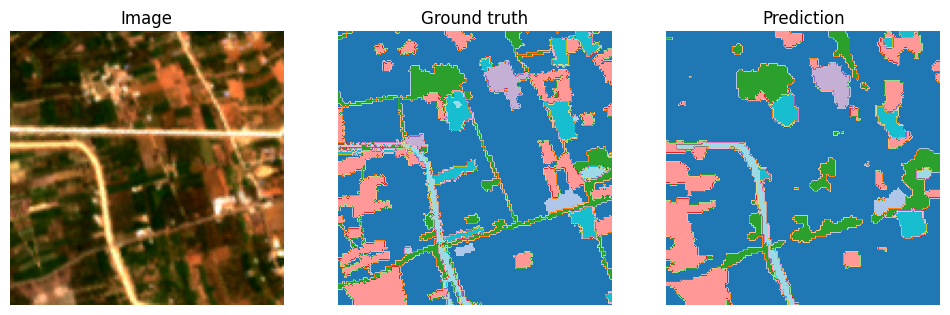

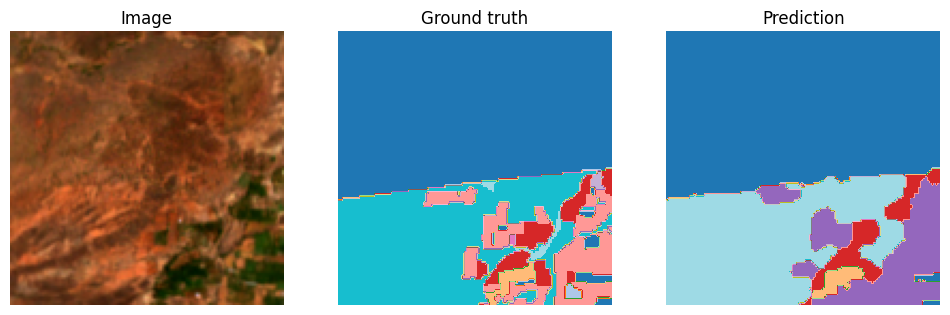

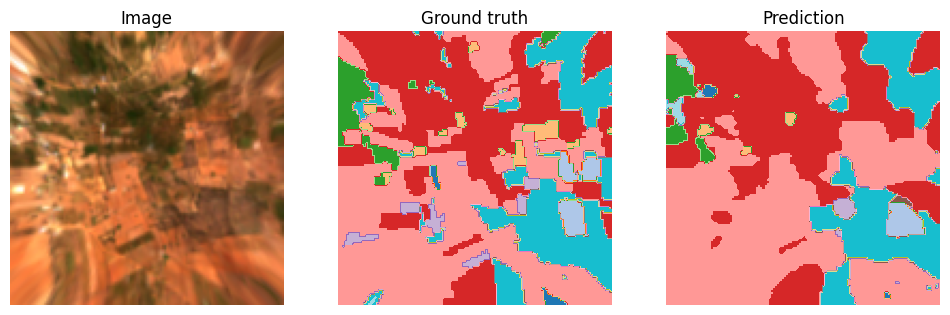

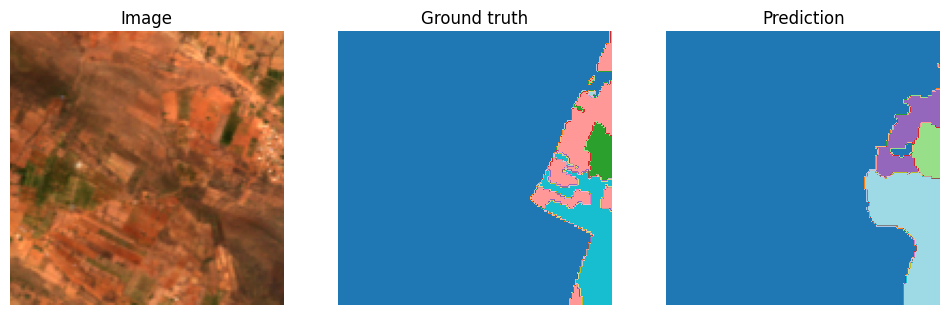

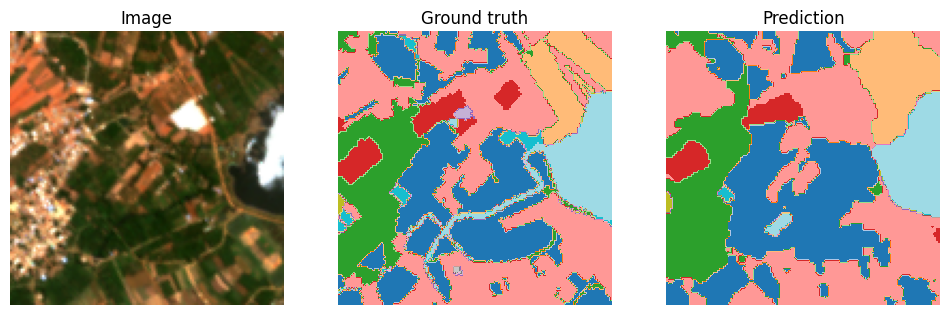

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Fetch a batch from the test loader
images, masks = next(iter(train_loader))

# Switch the model to evaluation mode
with torch.no_grad():
    model1.eval()
    logits = model1(images.to('cuda'))  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break